In [1]:
%matplotlib inline
# 默认是在notebook里面显示图形.
# 我们将从0开始实现整个方法, 包括数据流水线, 模型, 损失函数, 和小批量随机梯度下降优化器‘
# 现在使用的都是小批量随机梯度下降, 梯度是很贵的. 因此
# 可以帮助从底层了解我们的模型.

import torch  # torch
from d2l import torch as d2l  # 放在d2l包.
import random
from torch.utils import data

In [2]:
num_examples = 100

# 生成数据集. 好处是我们知道参数, 这样可以比较优化结果和实际参数的区别. 并且数据量较小, 方便我们理解整个深度学习的过程
def synthetic_data(w, b, num_examples):  # @save
    """生成Y = wX + b的噪声"""
    x = torch.normal(0, 1, (num_examples, len(w)))  # 参数分别是: 均值, 标准差, 以及形状. 也就是多少个样本.
    # 矩阵乘积要满足条件, 因此必须使用len(w), 在和w相乘前.
    y = torch.matmul(x, w) + b  # 计算b, 默认使用其中元素进行运算
    # 加上随机噪声
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape((-1, 1))  # 成为列向量.

# 真实True
true_w = torch.tensor([2, -3.4])
true_b = 4.2

# 生成随机数据
features, labels = synthetic_data(true_w, true_b, num_examples)  # 生成1000个样本数据.

In [3]:
print('features', features, "labels", labels)
# features表示样本元素, labels表示样本元素对应的真是label值.
# 这是一个线性回归问题, 因此值是不连续的, 并且是无线的.


features tensor([[-2.0615,  0.0359],
        [ 1.0301, -1.3225],
        [-1.4317,  1.0843],
        [-2.6109,  0.8439],
        [-0.3010,  0.2469],
        [ 0.2209, -0.0353],
        [-0.6492, -0.4403],
        [ 1.1196,  0.8198],
        [ 0.7070, -0.2932],
        [-0.4004, -0.4504],
        [-0.4605,  1.3740],
        [ 2.3324, -0.8164],
        [ 1.1595,  1.1712],
        [ 0.0208, -2.2443],
        [ 1.5806,  0.2634],
        [ 2.6939,  2.5766],
        [ 0.6000, -0.8738],
        [-0.5394, -0.0786],
        [-1.2050, -0.8925],
        [-1.8701,  0.7875],
        [ 0.4440,  1.1028],
        [ 1.8384,  0.1168],
        [ 0.2224,  0.0318],
        [-1.2939, -0.4517],
        [-0.6021, -0.0430],
        [ 0.9436, -1.3536],
        [ 0.3027,  1.4992],
        [-0.6881, -0.3886],
        [ 1.8186,  1.9086],
        [ 0.8407, -0.3475],
        [-0.0899, -0.1616],
        [-1.1364,  0.6506],
        [ 1.0518, -0.1950],
        [-1.1204, -0.6459],
        [-1.7514, -0.7393],
        [ 0

In [4]:
print(features[0], labels[0]) # 第一个数据对应其真实的label值.

tensor([-2.0615,  0.0359]) tensor([-0.0480])


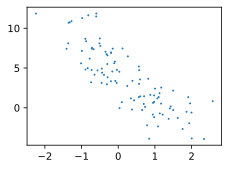

In [5]:
# 此时我们可以调用d2l中的图功能, 以此来查看整体样本关系
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
# d2l.plt.imshow()

# 使用detach()的目的, 是因为torch老版本中, 需要先将tensor, 从图中抽离出来, 所以就要使用detach()将数据抽离出来.

In [6]:
# 读取数据集:
# 我们回想一下对数据集进行遍历, 并且我们是小批量的样本, 来更新我们的模型
# 这是机器学习算法基础, 也就是我们必须要定义一个函数, 该函数能够打乱数据集合中的样本
def data_iter(batch_size, features, labels):
    num_example = len(labels)
    indices = list(range(num_example)) # 序列
    # 为什么是随机梯度下降: SGD, shuffle
    random.shuffle(indices) # 打乱index
    for i in range(0, num_example, batch_size): # 0到end, 每batchsize一组, 这样能保证遍历一边数据集
        tensor = torch.tensor(
            indices[i: min(i + batch_size, num_example)]  # 取出feature, min, 是考虑最后一组时, batch_size过大, 导致数组越界.
        )
        batch_indices = tensor
        # 使用生成器.
        yield features[batch_indices], labels[batch_indices]


In [7]:
batch_size = 10
# 使用迭代器, 取出数据
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break
# 但是这种迭代方式, 逻辑上是很清晰, 但是执行效率会很低. 尽管我们用上了iter. 可能会在实际问题上出现问题

tensor([[ 0.3653,  0.5671],
        [ 1.5277,  1.4972],
        [-1.5696,  0.3773],
        [ 2.6939,  2.5766],
        [-1.0283, -1.0142],
        [ 0.2224,  0.0318],
        [ 0.8109,  1.0026],
        [ 0.9436, -1.3536],
        [-0.4897,  0.5605],
        [ 0.9643, -0.4877]]) tensor([[ 3.0129],
        [ 2.1606],
        [-0.2214],
        [ 0.8301],
        [ 5.5854],
        [ 4.5369],
        [ 2.4124],
        [10.6956],
        [ 1.3284],
        [ 7.7831]])


In [8]:
# 然后定义模型
# 初始化参数:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True) # 并且我们是需要保留梯度的
b = torch.zeros(1, requires_grad=True)

w, b # 随机初始化参数

(tensor([[0.0107],
         [0.0051]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [9]:
# 定义模型
def linear_regression(X, w, b):
    """线性模型运算, 返回y_hat"""
    return torch.matmul(X, w) + b

In [10]:
# 定义损失函数:
def mean_squared_loss(y_hat, y):
    "均方损失"
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 #

In [11]:
# 定义优化算法:
def sgd(params, lr, batch_size):
    """
    这里使用的是小批量随机梯度下降,
    params is a container, include all parameter 
    can use a list data-struction, to include params.
    
    """
    with torch.no_grad(): # 不保存梯度, 这样能够计算的速度快一些. 
        for param in params: # 遍历每个参数, 都向－梯度更新. 
            param -= lr * param.grad / batch_size # 这里的batch_size是为了让模型更加平均的更新
            param.grad.zero_() # empty gradient

In [12]:
# 开始训练: 
# 设定超参数:
lr = 0.03
num_epoch = 10 # epoch 轮数
net = linear_regression # 网络
loss = mean_squared_loss # 损失函数
optimize = sgd # 优化算法

In [13]:
# 开始训练：
for epoch in range(num_epoch): # 每一轮
    # 扫一遍batch:
    for X, y in data_iter(batch_size, features, labels):
        # 计算y_hat
        y_hat = net(X, w, b)
        # 计算loss:
        loss_scalar = loss(y_hat, y)
        # 计算params梯度, 准备更新
        loss_scalar.sum().backward() # 我们通常是对一个标量进行求梯度的操作. 这样我们在反向传播
        # 有了grad随后进行更新:
        optimize([w, b], lr, batch_size)
    # 扫完所有的batch, 进行评估
    with torch.no_grad(): # 评估时, 不需要计算梯度, 节省资源
        train_loss_scalar = loss(net(features, w, b),  labels) # 计算一下每轮的损失
        print(f'epoch: {epoch+1}, loss: {float(train_loss_scalar.mean())}')

In [ ]:
# 看一下训练完后的真实值与估计值的差距:
print(f"difference of 'w': {true_w - w.reshape(true_w.shape)}")
print(f"difference of 'b': {true_b - b}")
# 可见, 经过训练差距还是非常小的. 

difference of 'w': tensor([-0.0090, -0.0321], grad_fn=<SubBackward0>)
difference of 'b': tensor([0.0274], grad_fn=<RsubBackward1>)
